# NeuralNetwork Gradient Descent Experiments

This notebook tests the `NeuralNetwork` class on the Kalshi dataset and compares **Batch**, **Mini-batch**, and **Stochastic** gradient descent runtime/performance.


In [1]:
import time

import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from neural_network import NeuralNetwork

plt.style.use('ggplot')
np.set_printoptions(suppress=True, precision=4)


In [2]:
SAMPLE_ROWS = 40000  # increase this to stress runtime more
TRAIN_FRACTION = 0.8

con = duckdb.connect()
query = f"""
WITH trade_outcomes AS (
    SELECT
        t.count::DOUBLE AS trade_size,
        CASE WHEN t.taker_side = 'yes' THEN t.yes_price ELSE t.no_price END::DOUBLE / 100.0 AS entry_price,
        t.yes_price::DOUBLE / 100.0 AS yes_price,
        t.no_price::DOUBLE / 100.0 AS no_price,
        EXTRACT(hour FROM t.created_time)::DOUBLE AS hour_of_day,
        EXTRACT(dow FROM t.created_time)::DOUBLE AS day_of_week,
        CASE WHEN t.taker_side = 'yes' THEN 1 ELSE 0 END::DOUBLE AS took_yes,
        CASE WHEN t.taker_side = m.result THEN 1 ELSE 0 END::DOUBLE AS won
    FROM 'data/kalshi/trades/*.parquet' t
    JOIN 'data/kalshi/markets/*.parquet' m USING (ticker)
    WHERE m.status = 'finalized'
      AND m.result IN ('yes', 'no')
      AND t.count > 0
      AND t.yes_price BETWEEN 1 AND 99
      AND t.no_price BETWEEN 1 AND 99
)
SELECT *
FROM trade_outcomes
USING SAMPLE {SAMPLE_ROWS} ROWS (reservoir)
"""

df = con.execute(query).df()
df.head()


,trade_size,entry_price,yes_price,no_price,hour_of_day,day_of_week,took_yes,won
0,50.0,0.09,0.09,0.91,19.0,6.0,1.0,0.0
1,40.0,0.80,0.20,0.80,15.0,2.0,0.0,1.0
2,100.0,0.86,0.14,0.86,13.0,0.0,0.0,0.0
3,15.0,0.06,0.06,0.94,12.0,1.0,1.0,0.0
4,53.0,0.82,0.82,0.18,20.0,6.0,1.0,1.0


In [3]:
feature_columns = [
    'trade_size',
    'entry_price',
    'yes_price',
    'no_price',
    'hour_of_day',
    'day_of_week',
    'took_yes',
]

X = df[feature_columns].to_numpy(dtype=np.float64)
y = df['won'].to_numpy(dtype=np.float64).reshape(-1, 1)

rng = np.random.default_rng(42)
indices = rng.permutation(X.shape[0])
split = int(TRAIN_FRACTION * X.shape[0])
train_idx = indices[:split]
test_idx = indices[split:]

X_train_raw = X[train_idx]
X_test_raw = X[test_idx]
y_train = y[train_idx].T
y_test = y[test_idx].T

mu = X_train_raw.mean(axis=0, keepdims=True)
sigma = X_train_raw.std(axis=0, keepdims=True)
sigma[sigma == 0] = 1.0

X_train = ((X_train_raw - mu) / sigma).T
X_test = ((X_test_raw - mu) / sigma).T

print('train features shape:', X_train.shape)
print('train labels shape:  ', y_train.shape)
print('test features shape: ', X_test.shape)
print('test labels shape:   ', y_test.shape)


train features shape: (7, 32000)
train labels shape:   (1, 32000)
test features shape:  (7, 8000)
test labels shape:    (1, 8000)


In [4]:
def accuracy_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(y_true == y_pred))


def run_experiment(label: str, mode: str, epochs: int, batch_size: int = 256):
    model = NeuralNetwork(
        layer_sizes=[X_train.shape[0], 16, 8, 1],
        learning_rate=0.03,
        random_seed=7,
    )

    train_kwargs = {
        'epochs': epochs,
        'print_every': max(1, epochs // 5),
        'gradient_descent': mode,
        'shuffle': True,
    }
    if mode == 'mini-batch':
        train_kwargs['batch_size'] = batch_size

    start = time.perf_counter()
    history = model.train(X_train, y_train, **train_kwargs)
    elapsed = time.perf_counter() - start

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return {
        'label': label,
        'mode': mode,
        'epochs': epochs,
        'batch_size': (batch_size if mode == 'mini-batch' else None),
        'runtime_sec': elapsed,
        'final_loss': history.losses[-1],
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'loss_curve': history.losses,
    }


In [10]:
experiments = [
    {'label': 'Batch GD', 'mode': 'batch', 'epochs': 80},
    {'label': 'Mini-batch GD (256)', 'mode': 'mini-batch', 'epochs': 60, 'batch_size': 256},
    {'label': 'Stochastic GD', 'mode': 'stochastic', 'epochs': 10},
]

results = []
for exp in experiments:
    print(f"\nRunning: {exp['label']}")
    result = run_experiment(
        label=exp['label'],
        mode=exp['mode'],
        epochs=exp['epochs'],
        batch_size=exp.get('batch_size', 256),
    )
    results.append(result)

results_df = pd.DataFrame([
    {k: v for k, v in item.items() if k != 'loss_curve'}
    for item in results
]).sort_values('runtime_sec')

results_df



Running: Batch GD
Epoch 1/80 - loss: 0.755613
Epoch 16/80 - loss: 0.678810
Epoch 32/80 - loss: 0.646736
Epoch 48/80 - loss: 0.629885
Epoch 64/80 - loss: 0.618745
Epoch 80/80 - loss: 0.610160

Running: Mini-batch GD (256)
Epoch 1/60 - loss: 0.592046
Epoch 12/60 - loss: 0.503716
Epoch 24/60 - loss: 0.500553
Epoch 36/60 - loss: 0.499128
Epoch 48/60 - loss: 0.498206
Epoch 60/60 - loss: 0.497545

Running: Stochastic GD
Epoch 1/10 - loss: 0.504323
Epoch 2/10 - loss: 0.510066
Epoch 4/10 - loss: 0.509122
Epoch 6/10 - loss: 0.497405
Epoch 8/10 - loss: 0.512332
Epoch 10/10 - loss: 0.506053


,label,mode,epochs,batch_size,runtime_sec,final_loss,train_accuracy,test_accuracy
0,Batch GD,batch,80,NaN,0.372706,0.610160,0.631531,0.617625
1,Mini-batch GD (256),mini-batch,60,256.0,0.620261,0.497545,0.746344,0.733875
2,Stochastic GD,stochastic,10,NaN,9.523452,0.506053,0.739563,0.729625


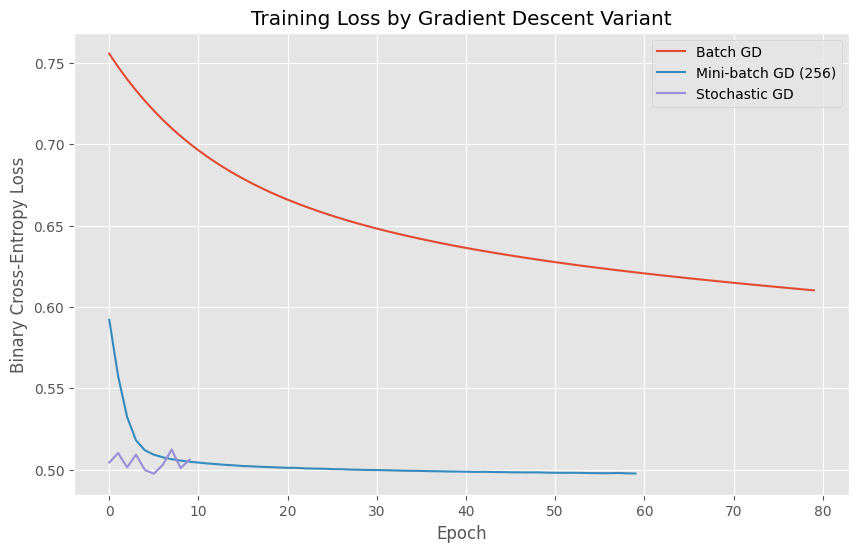

In [11]:
plt.figure(figsize=(10, 6))
for item in results:
    plt.plot(item['loss_curve'], label=item['label'])

plt.title('Training Loss by Gradient Descent Variant')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()
plt.show()


In [12]:
batch_runtime = float(results_df.loc[results_df['mode'] == 'batch', 'runtime_sec'].iloc[0])
mini_runtime = float(results_df.loc[results_df['mode'] == 'mini-batch', 'runtime_sec'].iloc[0])

print(f'Mini-batch speedup vs Batch: {batch_runtime / mini_runtime:.2f}x')
print('Tip: Increase SAMPLE_ROWS and/or epochs to stress runtime further.')


Mini-batch speedup vs Batch: 0.60x
Tip: Increase SAMPLE_ROWS and/or epochs to stress runtime further.
